In [1]:
import numpy as np
from project import Phase
import torch
import sys
from matplotlib import pyplot as plt

constants = {}
constants['progress'] = False
constants['c'] = 1.42
constants['Aeff'] = 7.29
constants['t_final'] = 300
constants['sim_method'] = 'discrete'
constants['ul_coord'] = [1500, 2800]
constants['lr_coord'] = [2723, 3905]
'''Should just set this to min tau_vec I think, which it basically already is'''
constants['min_tau'] = 2
constants['A_cell'] = 270**2 / 1e6 #km^2
constants['ncell_min'] = 2_500
constants['root'] = 0 #For mpi
constants.update({'final_max_tau': np.nan})
constants['meta_metric'] = 'gte_thresh'
constants.update({'metric': 'lambda_s'})
constants.update({'tauc_method': 'flat'})
constants.update({'overwrite_metrics': False}) 
constants['overwrite_results'] = False

pproc = Phase(**constants)
pproc.initialize()
assert pproc.metric_exp_spl(pproc.min_tau) > 0

[Mac.search.charter.net:02370] shmem: mmap: an error occurred while determining whether or not /var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T//ompi.Mac.501/jf.0/1020854272/sm_segment.Mac.501.3cd90000.0 could be created.
/Users/patrick/Research/Regan/TecateCypress/sensitivity/project.py:371: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/self.c)


#### Training data generation

0.986930292384002

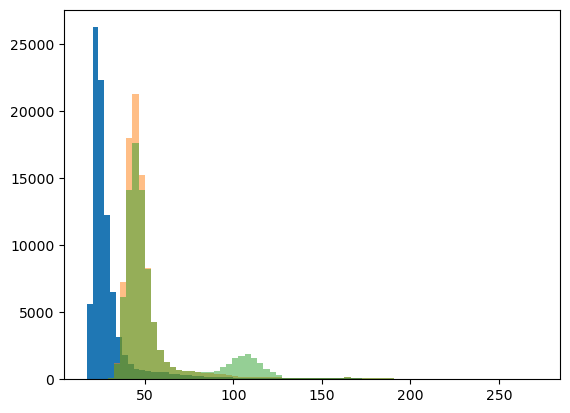

In [2]:
plt.hist(pproc.tau_flat, bins=70);
pproc.mu_tau = 20
pproc.sigm_tau = 3
pproc.generate_eps_tau(pproc.mu_tau, pproc.sigm_tau)
pproc.tau_expect = pproc.tau_flat + pproc.eps_tau
plt.hist(pproc.tau_expect, bins=70, alpha=0.5);

pproc.mu_tauc = 20
pproc.sigm_tauc = 8
pproc.change_tau_expect(5*pproc.ncell_tot, 10_000, 20_000)
plt.hist(pproc.tau_expect, bins=70, alpha=0.5);

pproc.calculate_metric_expect()
pproc.metric_expect

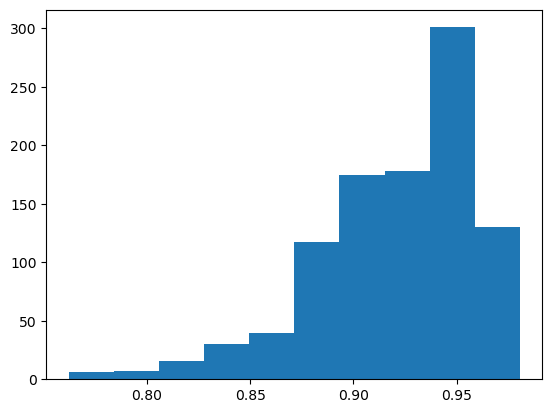

In [2]:
#### Get samples of each parameter we want to train on ####
NUM_TRAIN = 1000

# Function to return parameter combinations as dicts
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

# For sampling from various probability distributions
rng = np.random.default_rng()

# Theoretical (or ad-hoc) maxima/minima for parameters
minima = {
    'C': 5.*pproc.ncell_tot,
    'ncell': int(0.02*pproc.ncell_tot), 
    # 'ncell': int(pproc.ncell_tot - pproc.slice_right_max),
    'slice_left': int(0.* pproc.ncell_tot),
    'mu_tau': -10.,
    'sigm_tau': 0.,
    'mu_tauc': -10.,
    'sigm_tauc': 0.
}
maxima = {
    'C': 5.*pproc.ncell_tot,
    'ncell': int(1. * pproc.slice_right_max), 
    'slice_left': int(1.*pproc.ncell_tot),
    'mu_tau': 6.,
    'sigm_tau': 10.,
    'mu_tauc': 6.,
    'sigm_tauc': 10.
}
param_keys = np.array(list(minima.keys()))

# Generate parameter values for training
train_x = np.full((NUM_TRAIN, len(minima)), np.nan)
for param_i, ((key1, _min), (key2, _max)) in enumerate(zip(minima.items(), maxima.items())):
    assert(key1 == key2); key = key1 = key2
    
    try:
        assert (type(_min)==type(_min))
        _type = type(_min)
    except:
        print('hey thats bad', type(_min), type(_min)); sys.exit()
        
    # Skip slice_left for now, sample after ncell has been sampled
    if key == 'slice_left': continue 
    
    if _type == float:
        param_samples = rng.uniform(_min, _max, len(train_x))
    elif _type == int:
        param_samples = rng.integers(_min, _max, len(train_x))
    train_x[:, param_i] = param_samples
# Sample slice_left only where feasible given ncell samples
ncell_column = np.nonzero(param_keys == 'ncell')[0][0]
slice_left_max_vec = pproc.slice_right_max - train_x[:,ncell_column]
slice_left_column = np.nonzero(param_keys == 'slice_left')[0][0]
train_x[:, slice_left_column] = rng.uniform(0, slice_left_max_vec)

    
# Generate metric values for training
train_y = np.full((len(train_x), 1), np.nan)
for x_i, x in enumerate(train_x):
    for i, param in enumerate(param_keys):
        # Assign parameter values for this sample
        setattr(pproc, param, x[i].astype(type(minima[param])))
        
    if pproc.slice_left > (pproc.slice_right_max - pproc.ncell):
        continue # Skip bc slice start too high
        
    # Reset tau values to baseline
    pproc.tau_expect = pproc.tau_flat

    # Add in uncertainty on baseline tau values
    pproc.generate_eps_tau(pproc.mu_tau, pproc.sigm_tau)
    pproc.tau_expect = pproc.tau_flat + pproc.eps_tau

    # Shift selected tau values (including uncertainty)
    pproc.change_tau_expect(pproc.C, pproc.ncell, pproc.slice_left)
    
    # Compute and store metric value
    pproc.calculate_metric_expect()
    train_y[x_i] = pproc.metric_expect
plt.show()
plt.hist(train_y);

#### Viz sampled data

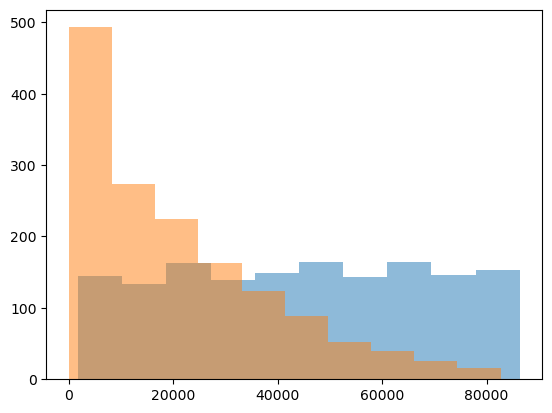

0
1


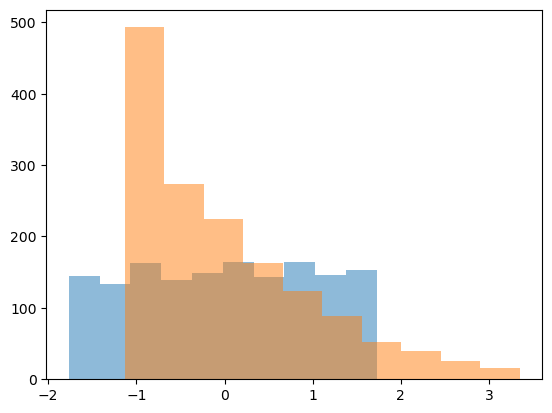

In [9]:
plt.hist(full_x[:,0], alpha=0.5);
plt.hist(full_x[:,1], alpha=0.5);
plt.show()

for i in range(full_x.shape[1]):
    print(i)
    mean = full_x[:, i].mean()
    std = full_x[:, i].std()
    full_x[:,i] = (full_x[:,i] - mean) / std
    plt.hist(full_x[:,i], alpha=0.5)

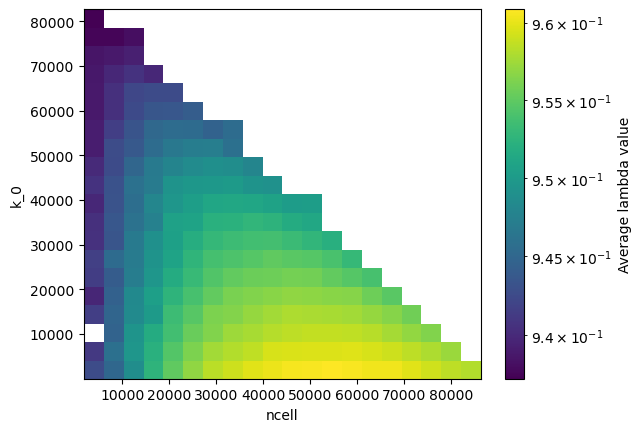

In [10]:
full_x = np.load('train_x.npy')
full_x = full_x[:, 1:3] # Drop everything except ncell and k0 for simple test
full_y = np.load('train_y.npy')
# Take a small subset to check
full_x = full_x[:1500, :]
full_y = full_y[:1500, :]

# Now refer to 'x', 'y', and 'z' ax axes on the following plot
x = full_x[:,0] # ncell
y = full_x[:,1] # slice_left
z = full_y[:,0] # metric value

# Define bins
x_bins = np.linspace(x.min(), x.max(), 21)  # 10 bins along x-axis
y_bins = np.linspace(y.min(), y.max(), 21)  # 10 bins along y-axis

# Calculate the average z value for each bin
z_means, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z, density=False)
counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Avoid division by zero
z_means = np.divide(z_means, counts, out=np.zeros_like(z_means), where=counts != 0)

# Create the heatmap
fig, ax = plt.subplots()
im = ax.imshow(z_means.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], aspect='auto', norm='log')

# Add colorbar
cbar = fig.colorbar(im)
cbar.set_label('Average lambda value')

# Set labels
ax.set_xlabel('ncell')
ax.set_ylabel('k_0')
# ax.set_title('Heatmap of Average z Values within Bins')

# Show the plot
plt.show()

#### Training

In [2]:
class Normalizer:
    def __init__(self, mean: torch.Tensor, std: torch.Tensor):
        """
        mean: Tensor of means (feature-wise for inputs, scalar for output)
        std: Tensor of standard deviations (feature-wise for inputs, scalar for output)
        """
        self.mean = mean
        self.std = std

    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        return (x - self.mean) / self.std

    def denormalize(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.std + self.mean

    def denormalize_variance(self, var: torch.Tensor) -> torch.Tensor:
        """
        De-normalize predicted variance.

        - For scalar output: var * std^2
        - For vector output: var * (std ** 2) elementwise
        """
        return var * (self.std ** 2)

In [61]:
# from NN_testing.NN_deterministic import *
from NN_models.deterministic import *
from NN_testing.EarlyStopping import EarlyStopping
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import timeit

torch.set_num_threads(torch.get_num_threads())

# BATCH_SIZE = 1024  # Tune this depending on your memory (try 64–1024)
# BATCH_SIZE = 2_048
BATCH_SIZE = 312  
# BATCH_SIZE = 64
PENALTY_WEIGHT = 1e-12
COMPLEXITY_COST_WEIGHT = None
PATIENCE = 100
SAMPLE_NBR = 1
NUM_EPOCHS = 1500
HIDDEN_DIM = 100

full_x = np.load('train_x.npy')
full_y = np.load('train_y.npy')
full_x = torch.from_numpy(full_x).float()
full_y = torch.from_numpy(full_y).float()
print("Original target stats:", full_y.mean(), full_y.std())

# # Drop the first column of inputs because we're keeping them constant for now (total resources)
# full_x = full_x[:, 1:]
# Actually drop everything except ncell and k0 for simple test
full_x = full_x[:, 1:3]

# Normalize the data before training
input_mean = full_x.mean(dim=0)  # shape: (n_features,)
input_std = full_x.std(dim=0)     # shape: (n_features,)
input_normalizer = Normalizer(input_mean, input_std)
full_x = input_normalizer.normalize(full_x)

output_mean = full_y.mean()
output_std = full_y.std()
output_normalizer = Normalizer(output_mean, output_std)
full_y = output_normalizer.normalize(full_y)

# Select a smaller slice of all generated data to use for training
NUM_TRAIN = 5_000
train_x = full_x[:NUM_TRAIN, :]
train_y = full_y[:NUM_TRAIN, :]

train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.1, random_state=42
)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False, num_workers=0)

val_dataset = TensorDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False, num_workers=0)

Original target stats: tensor(0.2577) tensor(0.0956)


In [66]:
from tqdm import tqdm
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

model = NN(input_dim=train_x.shape[1], hidden_dim = HIDDEN_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=1e-6)

start_time = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS)):
    epoch_start = timeit.default_timer()
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        train_loss = loss_fn(model, batch_x, batch_y, sample_nbr=SAMPLE_NBR, 
                             complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                             penalty_weight=PENALTY_WEIGHT)
        train_loss.backward()
        optimizer.step()
        epoch_loss += train_loss.item() * batch_x.size(0)  # Accumulate total loss

    epoch_loss /= len(train_dataset)  # Average over the full dataset
    
    # Validation step
    epoch_val_loss = 0.0
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model, batch_x, batch_y, sample_nbr=SAMPLE_NBR,
                               complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                               penalty_weight=PENALTY_WEIGHT)
        epoch_val_loss += val_loss.item() * batch_x.size(0)
    epoch_val_loss /= len(val_dataset)

    early_stopper(epoch_val_loss, model)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch}")
        print(f"Epoch {epoch}: Epoch loss = {epoch_loss:.4f} | Val Loss = {val_loss.item():.4f}")
        break
        
    if epoch % (NUM_EPOCHS // 20) == 0:
        print(f"Epoch {epoch}: Epoch loss = {epoch_loss:.4f} | Val Loss = {val_loss.item():.4f}")
        # print(f"Epoch {epoch}: Epoch loss = {epoch_loss:.4f}")
    
    # print(f"{timeit.default_timer() - epoch_start} seconds")

  0%|                                                  | 0/1500 [00:00<?, ?it/s]/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([312, 1])) that is different to the input size (torch.Size([312])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([132, 1])) that is different to the input size (torch.Size([132])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([188, 1])) that is differen

Epoch 0: Epoch loss = 1.3311 | Val Loss = 1.0985


  6%|██▍                                      | 87/1500 [00:01<00:24, 56.77it/s]

Epoch 75: Epoch loss = 0.9638 | Val Loss = 0.9165


 11%|████▏                                   | 159/1500 [00:03<00:24, 54.90it/s]

Epoch 150: Epoch loss = 0.9643 | Val Loss = 1.0340


 16%|██████▎                                 | 237/1500 [00:04<00:22, 56.48it/s]

Epoch 225: Epoch loss = 0.9642 | Val Loss = 0.9643


 16%|██████▌                                 | 245/1500 [00:04<00:23, 53.54it/s]

Early stopping at epoch 245
Epoch 245: Epoch loss = 0.9640 | Val Loss = 0.9309


tensor([-0.0169, -0.0165, -0.0150,  ..., -0.0117, -0.0170, -0.0099])


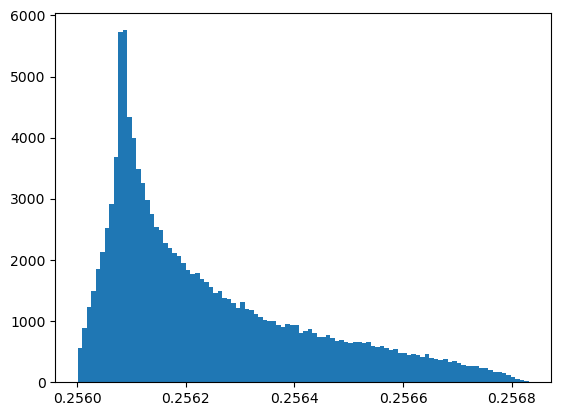

In [73]:
with torch.no_grad():
    test_x = full_x[NUM_TRAIN:,:]
    test_y = full_y[NUM_TRAIN:,:]
    # test_x = val_x.detach()
    # test_y = val_y.detach()

    pred_means, pred_vars = model(test_x)
    print(pred_means)
    pred_means = output_normalizer.denormalize(pred_means)
    pred_vars = output_normalizer.denormalize_variance(pred_vars)
    plt.hist(pred_means, density=True, bins=100);
    # plt.hist(test_y, density=True);
    # plt.xlim(-10,10)
    
    test_x = input_normalizer.denormalize(test_x)

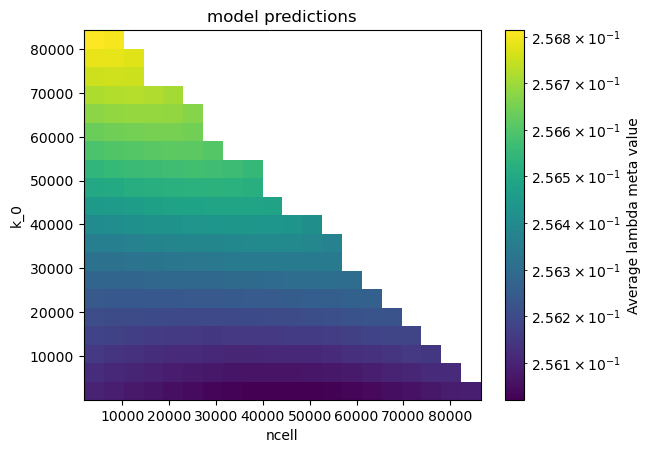

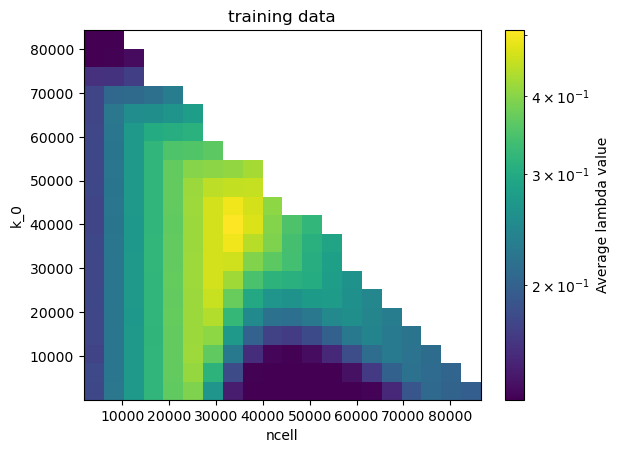

In [68]:
# Now refer to 'x', 'y', and 'z' ax axes on the following plot
x = test_x[:,0].numpy() # ncell
y = test_x[:,1].numpy() # slice_left
z = pred_means.numpy() # metric value

# Define bins
x_bins = np.linspace(x.min(), x.max(), 21)  # 10 bins along x-axis
y_bins = np.linspace(y.min(), y.max(), 21)  # 10 bins along y-axis

# Calculate the average z value for each bin
z_means, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z, density=False)
counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Avoid division by zero
z_means = np.divide(z_means, counts, out=np.zeros_like(z_means), where=counts != 0)

# Create the heatmap
fig, ax = plt.subplots()
im = ax.imshow(z_means.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
               aspect='auto', norm='log')

# Add colorbar
cbar = fig.colorbar(im)
cbar.set_label('Average lambda meta value')

# Set labels
ax.set_xlabel('ncell')
ax.set_ylabel('k_0')
ax.set_title('model predictions')

# Show the plot
plt.show()

#### Now plot the training data ####
z = output_normalizer.denormalize(test_y[:,0]).numpy() # metric value

# Define bins
y_bins = np.linspace(y.min(), y.max(), 21)  # 10 bins along y-axis

# Calculate the average z value for each bin
z_means, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], weights=z, density=False)
counts, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Avoid division by zero
z_means = np.divide(z_means, counts, out=np.zeros_like(z_means), where=counts != 0)

# Create the heatmap
fig, ax = plt.subplots()
im = ax.imshow(z_means.T, origin='lower', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
               aspect='auto', norm='log')

# Add colorbar
cbar = fig.colorbar(im)
cbar.set_label('Average lambda value')

# Set labels
ax.set_xlabel('ncell')
ax.set_ylabel('k_0')
ax.set_title('training data')

# Show the plot
plt.show()

In [70]:
with torch.no_grad():
    test_x = full_x[NUM_TRAIN:,:]
    test_y = full_y[NUM_TRAIN:,:]

    pred_mean_norm, _ = model(test_x)
    print("Normalized pred:", pred_mean_norm[:5])
    pred_mean = output_normalizer.denormalize(pred_mean_norm)
    print("Denormalized pred:", pred_mean[:5])
    
    true_y = output_normalizer.denormalize(test_y)
    print("True y range:", true_y.min().item(), true_y.max().item())
    print("Pred y range:", pred_mean.min().item(), pred_mean.max().item())
    
print("Target stats:", full_y.mean().item(), full_y.std().item())
print("Pred (norm):", pred_mean_norm[:5].numpy())
print("Pred (denorm):", pred_mean[:5].numpy())

Normalized pred: tensor([-0.0169, -0.0165, -0.0150, -0.0175, -0.0167])
Denormalized pred: tensor([0.2561, 0.2561, 0.2563, 0.2561, 0.2561])
True y range: 0.13102178275585175 0.5323377847671509
Pred y range: 0.2560013234615326 0.25683099031448364
Target stats: -6.019592291295339e-08 1.0
Pred (norm): [-0.01693025 -0.01653126 -0.01500868 -0.01749803 -0.01670266]
Pred (denorm): [0.2561058  0.25614396 0.25628945 0.25605154 0.25612757]


# 